In [1]:
from torch.utils.data import Dataset
import cv2
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import random 
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.CE_loss = nn.CrossEntropyLoss(
            reduction=reduction, ignore_index=ignore_index, weight=alpha)

    def forward(self, output, target):
        logpt = self.CE_loss(output, target)
        pt = torch.exp(-logpt)
        loss = ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()


class BCELoss(nn.Module):
    def __init__(self, reduction="mean", pos_weight=1.0):
        pos_weight = torch.tensor(pos_weight).cuda()
        super(BCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(
            reduction=reduction, pos_weight=pos_weight)

    def forward(self, prediction, targets):
        return self.bce_loss(prediction, targets)


class CELoss(nn.Module):
    def __init__(self, weight=[1, 1], ignore_index=-100, reduction='mean'):
        super(CELoss, self).__init__()
        weight = torch.tensor(weight).cuda()
        self.CE = nn.CrossEntropyLoss(
            weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target.squeeze(1).long())
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)
        intersection = 2 * torch.sum(prediction * target) + self.smooth
        union = torch.sum(prediction) + torch.sum(target) + self.smooth
        loss = 1 - intersection / union
        return loss


class CE_DiceLoss(nn.Module):
    def __init__(self, reduction="mean", D_weight=0.5):
        super(CE_DiceLoss, self).__init__()
        self.DiceLoss = DiceLoss()
        self.BCELoss = BCELoss(reduction=reduction)
        self.D_weight = D_weight

    def forward(self, prediction, targets):
               return self.D_weight * self.DiceLoss(prediction, targets) + (1 - self.D_weight) * self.BCELoss(prediction,targets)
                   

In [4]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)
model.load_state_dict(torch.load('checkpoint2_epoch_5.pth'))

<All keys matched successfully>

In [5]:
model.eval()

# --- Paths ---
image_dir = "data/images"
mask_dir = "data/veins"

# Get all image filenames
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(image_dir, random_image)

# Generate corresponding mask path
mask_filename = f"{random_image[:-4]}_vessels.png"
mask_path = os.path.join(mask_dir, mask_filename)

print("Random image path:", image_path)
print("Corresponding ground truth path:", mask_path)


# --- Load and Preprocess Image with CLAHE ---

img_og = Image.open(image_path).convert('RGB')
size_og = img_og.size
img_np = np.array(img_og)
# img_np = apply_clahe(img_np)
img = Image.fromarray(img_np)

vessels_mask = None 

try: 
    vessels_mask = Image.open(mask_path).convert("L")
except:
    print("Vessel Mark not Present.")
    pass

# Define transform to match training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Transform and prepare input
input_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 128, 128]

# --- Inference ---
with torch.no_grad():
    output = model(input_tensor)
    prediction = (output.squeeze(0).squeeze(0) > 0.4).cpu().numpy().astype(np.uint8)

Random image path: data/images\47R_r_1.jpg
Corresponding ground truth path: data/veins\47R_r_1_vessels.png
Vessel Mark not Present.


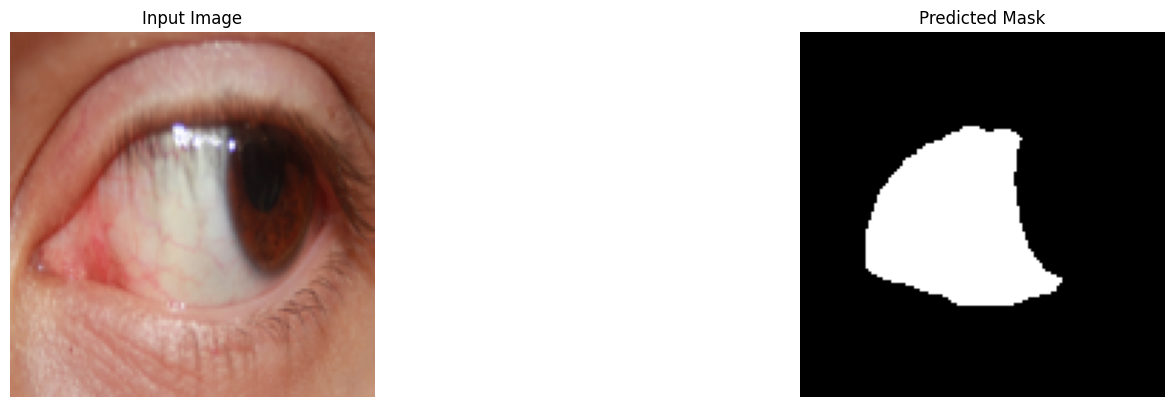

In [6]:

# --- Optional: Load and preprocess ground truth mask ---
mask = None
if os.path.exists(mask_path):
    mask_img = Image.open(mask_path).convert('L')
    mask = transform(mask_img).squeeze().cpu().numpy()

# --- Visualization ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img.resize((128, 128)))
plt.axis('off')

if mask is not None:
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(prediction, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

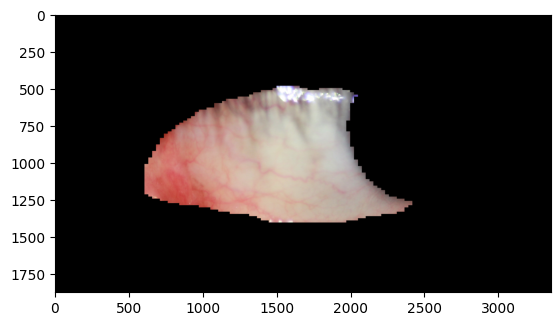

In [7]:
prediction_resized = cv2.resize(prediction, size_og, interpolation=cv2.INTER_NEAREST)

kernel = np.ones((3, 5), np.uint8)
mask_closed = cv2.morphologyEx(prediction_resized, cv2.MORPH_CLOSE, kernel)

original_img_np = np.array(img_og)

masked_img = original_img_np * mask_closed[..., np.newaxis]


plt.imshow(masked_img)
plt.show()

## Stage 2

In [8]:
# IMG_SIZE = (512,512)
IMG_SIZE = (1024,1024)

In [9]:
def preprocess_for_unet(masked_img):
    img = np.array(masked_img)
    img_green = img[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    img_green_clahe = clahe.apply(img_green)

    img_clahe_gray = Image.fromarray(img_green_clahe)

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])

    img_tensor = transform(img_clahe_gray)



    return img_tensor


In [10]:
unet_model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation=None
).to(device)

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.CE_loss = nn.CrossEntropyLoss(
            reduction=reduction, ignore_index=ignore_index, weight=alpha)

    def forward(self, output, target):
        logpt = self.CE_loss(output, target)
        pt = torch.exp(-logpt)
        loss = ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()


class BCELoss(nn.Module):
    def __init__(self, reduction="mean", pos_weight=1.0):
        pos_weight = torch.tensor(pos_weight).cuda()
        super(BCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(
            reduction=reduction, pos_weight=pos_weight)

    def forward(self, prediction, targets):
        return self.bce_loss(prediction, targets)


class CELoss(nn.Module):
    def __init__(self, weight=[1, 1], ignore_index=-100, reduction='mean'):
        super(CELoss, self).__init__()
        weight = torch.tensor(weight).cuda()
        self.CE = nn.CrossEntropyLoss(
            weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target.squeeze(1).long())
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)
        intersection = 2 * torch.sum(prediction * target) + self.smooth
        union = torch.sum(prediction) + torch.sum(target) + self.smooth
        loss = 1 - intersection / union
        return loss


class CE_DiceLoss(nn.Module):
    def __init__(self, reduction="mean", D_weight=0.5):
        super(CE_DiceLoss, self).__init__()
        self.DiceLoss = DiceLoss()
        self.BCELoss = BCELoss(reduction=reduction)
        self.D_weight = D_weight

    def forward(self, prediction, targets):
        return self.D_weight * self.DiceLoss(prediction, targets) + (1 - self.D_weight) * self.BCELoss(prediction,
                                                                                                       targets)


In [12]:
# unet_model.load_state_dict(torch.load('checkpoint_epoch_30.pth'))
unet_model.load_state_dict(torch.load('checkpoint2_epoch_50.pth'))
unet_model.eval()

img = preprocess_for_unet(masked_img).to(device)

with torch.no_grad():
    pred = unet_model(img.unsqueeze(0))[0][0].cpu().sigmoid().numpy()
    pred = (pred > 0.4).astype(np.uint8)

pred = cv2.resize(pred, size_og, interpolation=cv2.INTER_NEAREST)


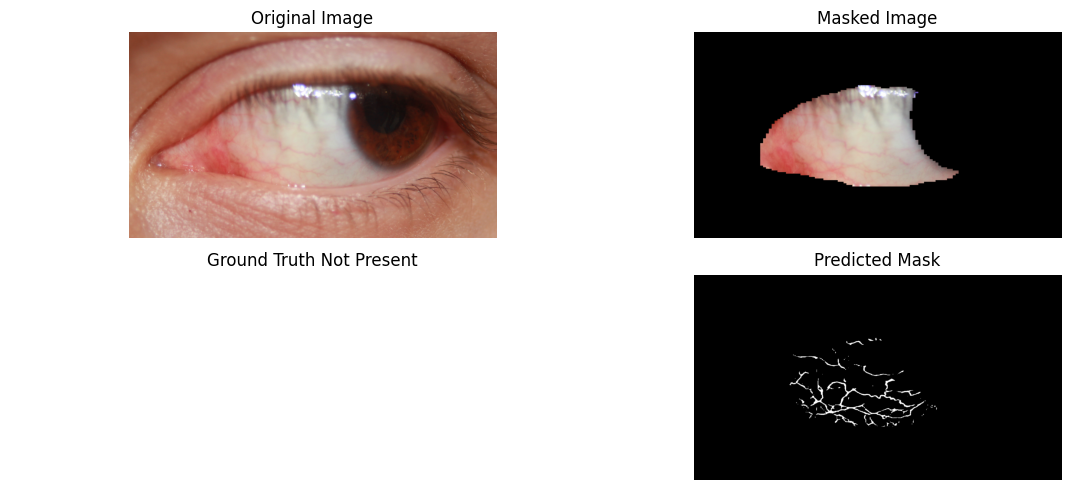

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img_og)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Masked Image")
plt.imshow(masked_img)
plt.axis('off')

if(vessels_mask != None):
    plt.subplot(2, 2, 3)
    plt.title("Ground Truth")
    plt.imshow(vessels_mask, cmap='gray')
    plt.axis('off')
else:
    plt.subplot(2, 2, 3)
    plt.title("Ground Truth Not Present")
    plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Predicted Mask")
plt.imshow(pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


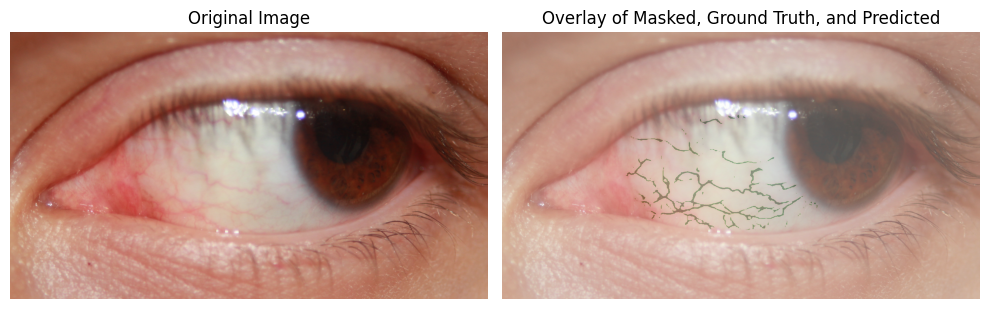

In [14]:
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_og)
plt.axis('off')

# Overlay
plt.subplot(1, 2, 2)
plt.title("Overlay of Masked, Ground Truth, and Predicted")
plt.imshow(img_og)

# # Overlay masked image
# plt.imshow(masked_img, alpha=0.3)

# # Overlay ground truth (in red if present)
# if vessels_mask is not None:
#     plt.imshow(vessels_mask, cmap='Reds', alpha=0.3)

# Overlay predicted mask (in green)
plt.imshow(pred, cmap='Greens', alpha=0.3)

plt.axis('off')
plt.tight_layout()
plt.show()
